In [1]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt


SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

# *Classic LASSO through Successive Convex Approximations (kinda overkilling...)*

In [2]:
def softshrink(x, lambda_):
    return np.sign(x) * np.maximum(0, np.abs(x) - lambda_)

In [3]:
x = np.zeros(200)
x[np.random.choice(200, 4)] = np.random.normal(scale=0.5, size = 4)

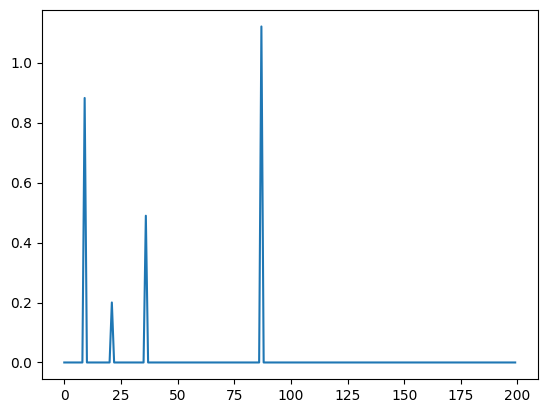

In [4]:
plt.plot(x)

In [5]:
A = np.random.normal(size = (150,200))
A /= np.linalg.norm(A, axis = 0)

In [6]:
y = A @ x 

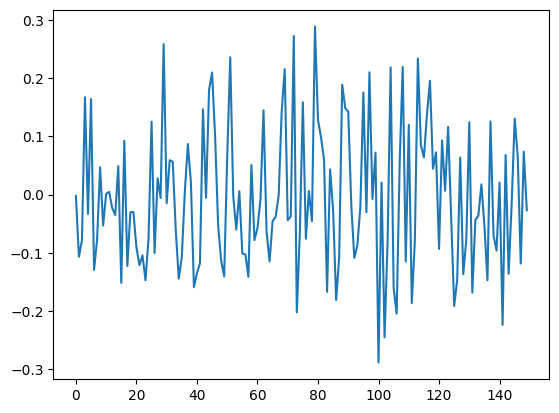

In [7]:
plt.plot(y)

In [8]:
def LASSO_SCA(y, A, tau_, lambda_, gamma, max_iter = 200):
    N = A.shape[1]

    x = np.zeros(N)
    tau = np.ones(N)*tau_ 

    for _ in tqdm(range(max_iter)):
        x_hat = np.zeros(N)
        for i in range(N):
            A_ = np.copy(A)
            A_[:,i] = 0

            x_ = np.copy(x)
            x_[i] = 0
            
            y_i = y - A_ @ x_
            
            # Local optimization step
            x_hat[i] = 1/(tau[i] + np.linalg.norm(A[:,i])) * softshrink(A[:,i].T @ y_i + tau[i]*x[i], lambda_)
        
        # Global smoothing step
        x = x + gamma*(x_hat - x)

        # Decreasing stepsize
        gamma = gamma * 0.99

    return x

In [9]:
x_1 = LASSO_SCA(y, A, 1, 0.1, 1)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:13<00:00, 15.07it/s]


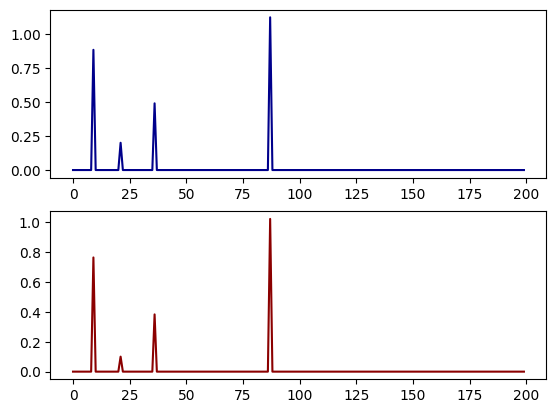

In [10]:
fig, axs = plt.subplots(2)

axs[0].plot(x, color='darkblue')
axs[1].plot(x_1, color='darkred')

plt.show()

_________________

# *Enforcing non convexity* 

The problem is now casted as a nonconvex one through a penalization term $-2C||x||^2$ so we want to figure out which value of $C$ makes the problem nonconvex one. It is easy to show that we need $A^TA$ to have at least a negative eigenvalues, so it is enough for $C$ to be $C > \frac{\lambda_{min}{(A^TA)}}{2}$.

In [11]:
lambdas = np.sort(np.real(np.linalg.eigvals(A.T @ A)))

for i in range(lambdas.shape[0]):
    if np.isclose(lambdas[i], 0.0, atol=1e-10):
        continue
    else:
        break

lambda_min = lambdas[i] 
c_cap = 1

In [12]:
c_cap > lambda_min/2

True

In [13]:
def NC_LASSO_SCA(A, y, NC, c = 0.1, tau = 1, gamma = 1, max_iter = 2000):
    M = A.shape[0]
    N = A.shape[1]

    x = np.zeros(N)
    tau = np.ones(N)*tau
    
    for _ in tqdm(range(max_iter)):
        # initialize a vector to enable Jacobi decomposition
        x_hat = np.zeros(N)

        for i in range(N):
            # Signaling for local problems
            A_ = np.copy(A)
            A_[:,i] = 0

            x_ = np.copy(x)
            x_[i] = 0
            
            y_i = y - A_ @ x_
            
            # Local optimization step
            x_hat[i] = 1/(tau[i] + np.linalg.norm(A[:,i] - 2*NC)) * softshrink(A[:,i].T @ y_i + tau[i]*x[i], c)
        
        # Global smoothing step
        x = x + gamma*(x_hat - x)
        gamma = gamma * 0.99
    
    return x

100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


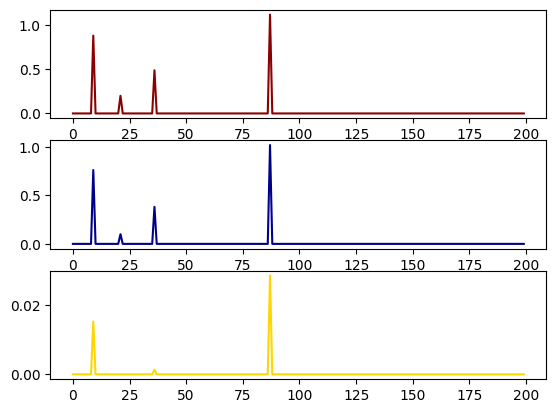

In [14]:
x_2 = NC_LASSO_SCA(A, y, c_cap, 0.4, 50, 1, max_iter = 100)

fig, axs = plt.subplots(3)

axs[0].plot(x, color='darkred')         # Original signal
axs[1].plot(x_1, color='darkblue')      # Classic LASSO via Successive convex approximation
axs[2].plot(x_2, color='gold')          # Non-convex LASSO via Successive convex approximation


plt.show()

___________________________

# *DeepUnfolding for SCA @ Nonconvex LASSO*

In [15]:
class SyntheticSignals():
    def __init__(self, A, n, m, s, s_sigma = 0.5, eps_sigma = 0.01, size = 1000, batch_size = 256):
        
        self.n = n          # Number of samples in the original signal
        self.m = m          # Number of samples through the linear transformation

        self.size = size    # Size of the dataset

        self.x = torch.zeros(self.size,self.n)
        self.y = torch.zeros(self.size,self.m)

        self.A = A          # Matrix for the linear observation

        self.s = s          # Sparsity of the signal

        self.s_sigma = s_sigma
        self.eps_sigma = eps_sigma

        self.batch_size = batch_size

        # Generating the dataset
        self.set_data()


    def set_tuple(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        idxs = np.random.choice(self.m, self.s, replace=False)
        peaks = np.random.normal(scale=self.s_sigma, size = self.s)

        # Generating the original signal and its corrupted observations
        self.x[i, idxs] = torch.from_numpy(peaks).to(self.x)
        self.y[i,:] = self.A @ self.x[i,:] + np.random.normal(scale=self.eps_sigma, size=self.m)


    def set_data(self):
        for i in range(self.size):
            self.set_tuple(i)
    
    
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.y, self.x),
                               batch_size = self.batch_size,
                               shuffle = True)

In [52]:
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
s_ = 4

# Measurement matrix
A_ = torch.randn(150,200)
A_ /= torch.norm(A_, dim=0)

# Building a training set and a test set 
train_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 800).set_loader()

test_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 160).set_loader()

In [53]:
lambdas, _ = torch.sort(torch.real(torch.linalg.eigvals(A_.T @ A_)))

for i in range(lambdas.shape[0]):
    if torch.isclose(lambdas[i], torch.tensor(0.0), atol=1e-10):
        continue
    else:
        break

lambda_min = lambdas[i] 
c_cap = 1

c_cap > lambda_min/2

tensor(True)

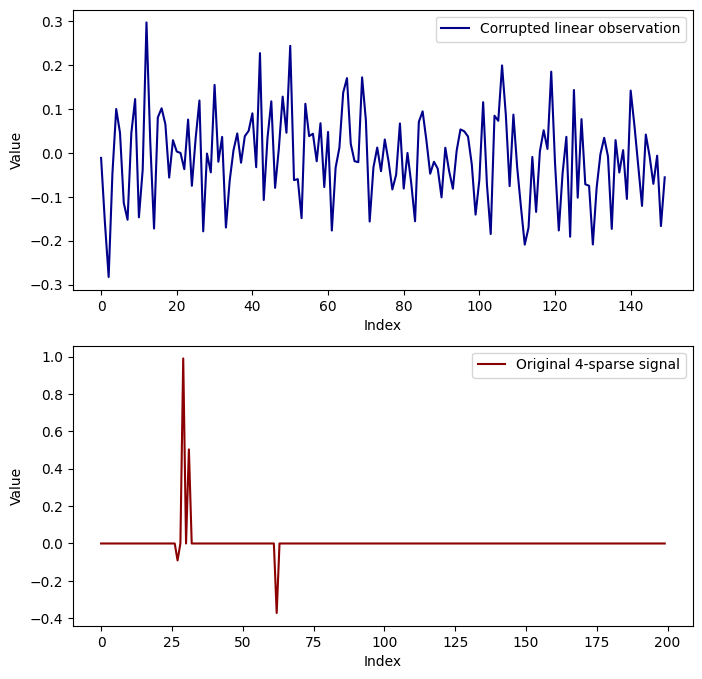

In [54]:
y_ex, x_ex = test_set.dataset.__getitem__(0)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(y_ex, label = 'Corrupted linear observation', color = 'darkblue')
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2)
plt.plot(x_ex, label = 'Original 4-sparse signal', color='darkred')
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.show()

100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


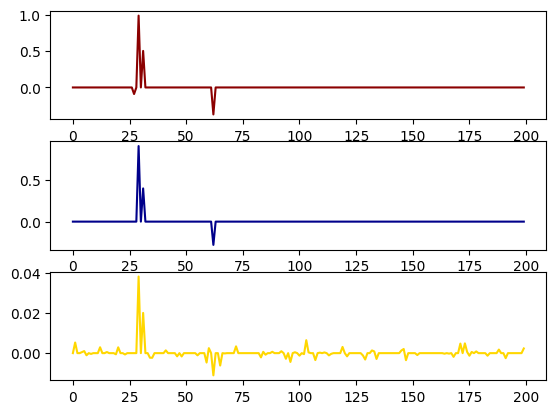

In [55]:
x_1 = LASSO_SCA(y_ex.detach().numpy(), A_, 1, 0.1, 1, max_iter = 10)
x_2 = NC_LASSO_SCA(A_, y_ex.detach().numpy(), c_cap, 0.1, 1, 1, max_iter = 100)

fig, axs = plt.subplots(3)

axs[0].plot(x_ex, color='darkred')      # Original signal
axs[1].plot(x_1, color='darkblue')      # Classic LASSO via Successive convex approximation
axs[2].plot(x_2, color='gold')          # Non-convex LASSO via Successive convex approximation


plt.show()

In [56]:
class SCA_LAYER(nn.Module):
    def __init__(self, A, NC, c = 0.01, tau = 1, gamma = 0.0005):
        super().__init__()

        # Measurement matrix 
        self.A = A
        self.N = self.A.shape[1]
        self.M = self.A.shape[0]

        # Parameter inducing concavity in the problem
        self.NC = NC

        # Initialization of the learnable parameters
        self.c = nn.Parameter(torch.ones(1)*c, requires_grad = True)
        self.tau = nn.Parameter(torch.ones(1)*tau, requires_grad = True)
        self.B = nn.Parameter(torch.randn(self.A.shape[1]), requires_grad = True)
        self.gamma = gamma

    def softshrink(self, x, L):
        return torch.sign(x) * torch.maximum(torch.zeros_like(x), torch.abs(x) - L)
    
    '''
    # Decomposed forward
    def forward(self, y, x):
        # initialize a vector to enable Jacobi decomposition
        x_hat = torch.zeros((y.shape[0],self.N))

        for i in range(self.N):
            # Signaling for local problems
            A_ = torch.clone(self.A)
            A_[:,i] = 0

            x_ = torch.clone(x)
            x_[:,i] = 0
            
            y_i = (y - (A_ @ x_.T).T).T
            
            # Local optimization step
            Z = torch.ones(y.shape[0]) * 1/(self.tau[0,i] + np.linalg.norm(self.A[:,i] - 2*self.NC))
            x_hat[:,i] = Z * self.softshrink((self.A[:,i].T @ y_i).T + self.tau[0,i] * x[:,i], self.c)
        
        # Global smoothing step
        return x + self.gamma*(x_hat - x)
    '''
    
    def forward(self, y, x):       
        # Local optimization step
        H = torch.outer(self.B,self.B) + self.tau*torch.eye(self.B.shape[0])
        Z = torch.linalg.inv(self.A.T @ self.A + H - 2*self.NC*torch.eye(self.A.shape[1]))
        x_hat = (Z @ self.softshrink((self.A.T @ y.T).T + (H @ x.T).T, self.c).T).T

        return x + self.gamma*(x_hat - x)


In [57]:
class DeepUnfSCA(nn.Module):
    def __init__(self, A, NC, T = 10, c = 0.1, tau = 25, gamma = 0.99, batch_size = 256):
        super(DeepUnfSCA, self).__init__()
        self.batch_size = batch_size

        # Measurements matrix
        self.A = A

        # Nonconvexity parameter
        self.NC = NC
        
        # Number of iterations <-> number of layers
        self.T = T

        # Initialization of the learnable parameters
        self.c_0 = torch.ones(T)*c
        self.tau_0 = torch.ones(T)*tau
        self.gamma_0 = torch.ones(T)*gamma
        for i in range(self.T):
            self.gamma_0[i] *= 0.99**i
            
        # Defining the layers
        self.SCA_layers = nn.ModuleList([SCA_LAYER(self.A, 
                                                   self.NC, 
                                                   self.c_0[i], 
                                                   self.tau_0[i], 
                                                   self.gamma_0[i]
                                                   ) for i in range(self.T)])

    def forward(self, y):
        x = torch.zeros((y.shape[0], self.A.shape[1]))
        for i in range(self.T-1):
            x = self.SCA_layers[i].forward(y, x)

        return self.SCA_layers[self.T-1].forward(y, x)


In [58]:
def train(model, train_loader, valid_loader, num_epochs=20):

    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for _, (b_x, b_s) in enumerate(train_loader):
            s_hat = model(b_x)
            loss = F.mse_loss(s_hat, b_s, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
            model.zero_grad()
            train_loss += loss.data.item()

        # Aggregate loss
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for _, (b_x, b_s) in enumerate(valid_loader):
            s_hat = model(b_x)
            test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        if epoch % 10 == 0:
            print("Epoch %d, Train loss %.8f, Validation loss %.8f" % (epoch, loss_train[epoch], loss_test[epoch]))

    return loss_test, b_x, b_s

In [59]:
model = DeepUnfSCA(A_, c_cap, T = 20)

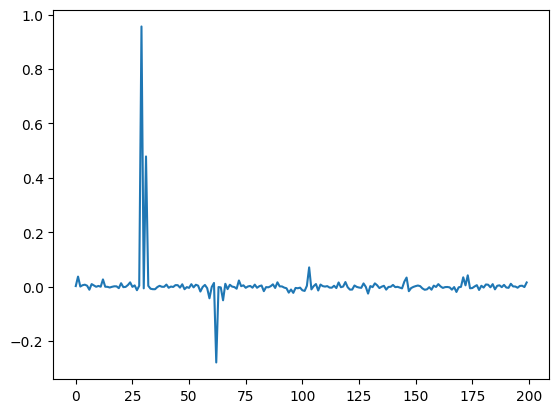

In [60]:
plt.plot(model.forward((y_ex[None,:]))[0].detach().numpy())

In [61]:
train(model, train_set, test_set)

Epoch 0, Train loss 0.05993196, Validation loss 0.06956631
Epoch 10, Train loss 0.05537230, Validation loss 0.06262464


(array([0.06956631, 0.06752311, 0.06567169, 0.06433746, 0.06351737,
        0.06306163, 0.06282767, 0.06271139, 0.06265686, 0.06262801,
        0.06262464, 0.06264202, 0.0626628 , 0.06269169, 0.06271651,
        0.0627295 , 0.06273647, 0.06274161, 0.06273864, 0.06271035]),
 tensor([[-0.0128,  0.0315,  0.0330,  ..., -0.0179,  0.0231,  0.0497],
         [-0.0065, -0.0267, -0.0639,  ...,  0.0708, -0.0189, -0.1006],
         [-0.1623, -0.0721,  0.2152,  ..., -0.1206,  0.1030,  0.0133],
         ...,
         [ 0.1097,  0.0330, -0.1453,  ...,  0.0515, -0.0464,  0.0168],
         [ 0.0090,  0.0395, -0.0400,  ..., -0.0145,  0.0359,  0.0052],
         [ 0.0767,  0.0173,  0.0318,  ...,  0.0025,  0.0496, -0.0160]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [47]:
[model.SCA_layers[i].gamma for i in range(model.T)]

[tensor(0.9900),
 tensor(0.9801),
 tensor(0.9703),
 tensor(0.9606),
 tensor(0.9510),
 tensor(0.9415),
 tensor(0.9321),
 tensor(0.9227),
 tensor(0.9135),
 tensor(0.9044),
 tensor(0.8953),
 tensor(0.8864),
 tensor(0.8775),
 tensor(0.8687),
 tensor(0.8601),
 tensor(0.8515),
 tensor(0.8429),
 tensor(0.8345),
 tensor(0.8262),
 tensor(0.8179)]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


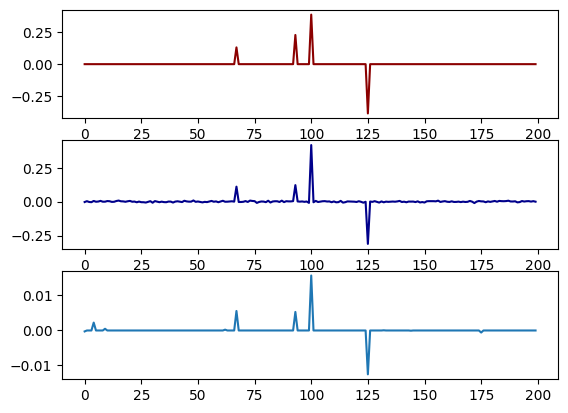

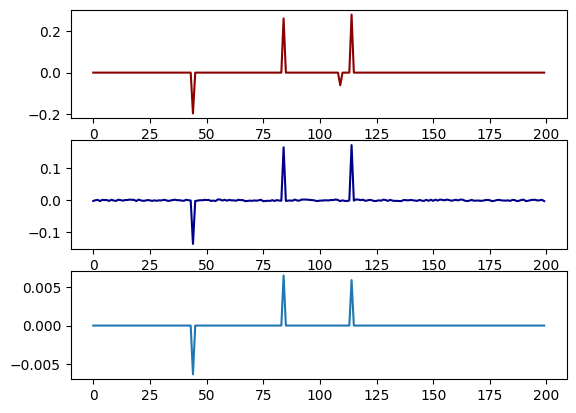

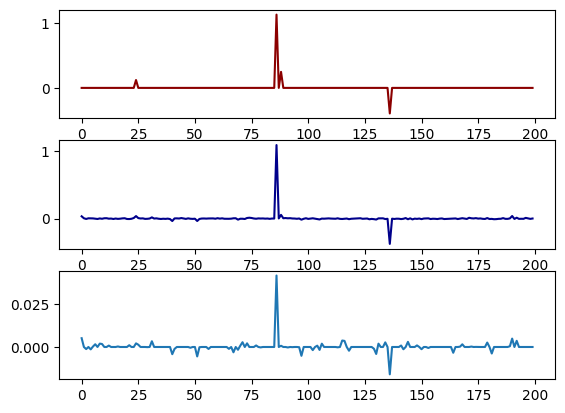

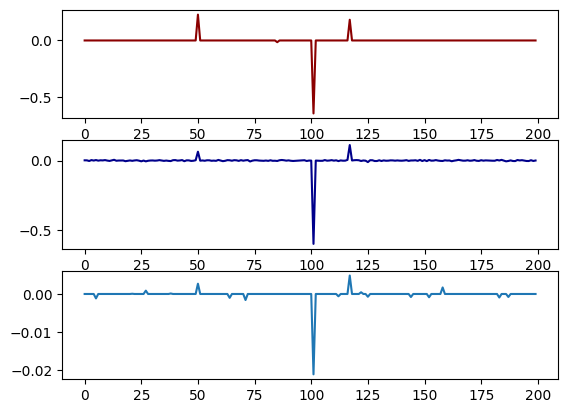

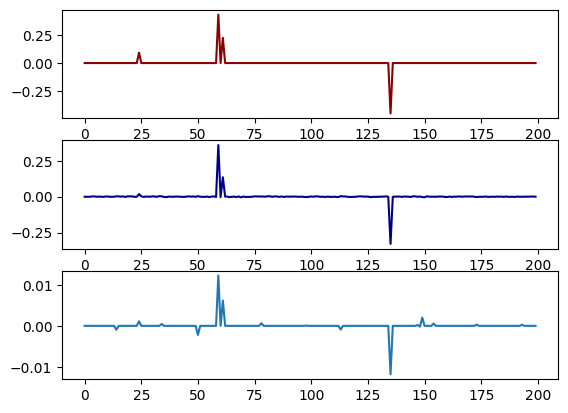

In [50]:
for i in range(5):
    y_ex, x_ex = test_set.dataset.__getitem__(i)
    fig, axs = plt.subplots(3)

    axs[0].plot(x_ex, color='darkred')      
    axs[1].plot(model.forward(y_ex[None,:])[0].detach().numpy(), color='darkblue')     
    axs[2].plot(NC_LASSO_SCA(A_, y_ex.detach().numpy(), c_cap, 0.1, 1, 1, max_iter = 100))

In [ ]:
T_ = 30
loss_SCA = []
loss_DUSCA = []

for T in range (3,T_,2):

    loss_SCA_ = 0
    for _, (y, x) in enumerate(test_set.dataset):
        x_hat = NC_LASSO_SCA(A_.detach().numpy(), y.detach().numpy(), NC = c_cap, max_iter=T)
        loss_SCA_ += (np.linalg.norm(x_hat - x.detach().numpy()))**2

    loss_SCA.append(loss_SCA_ / len(test_set.dataset))

    model = DeepUnfSCA(A_, c_cap, T=T)
    loss_DUADMM_, _ , _ = train(model, train_set, test_set)
    loss_DUSCA.append(loss_DUADMM_[-1])

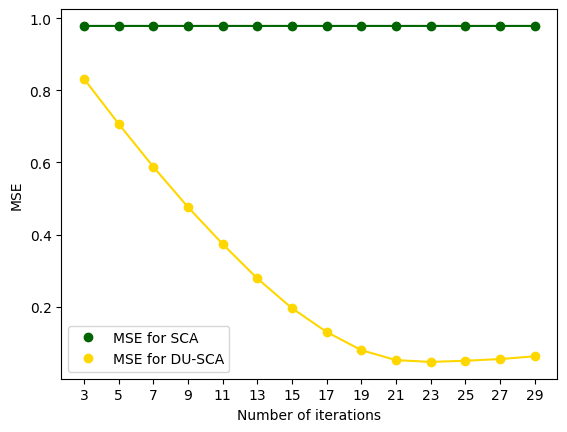

In [66]:
plt.plot(loss_SCA, label = 'MSE for SCA', marker='o', linestyle='',color = 'darkgreen')
plt.plot(loss_DUSCA, label = 'MSE for DU-SCA', marker='o', linestyle='',color = 'gold')
plt.plot(loss_SCA, color = 'darkgreen')
plt.plot(loss_DUSCA, color = 'gold')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],[3,5,7,9,11,13,15,17,19,21,23,25,27,29])
plt.xlabel('Number of iterations', fontsize=10)
plt.ylabel('MSE', fontsize=10)
  

plt.legend()

___________________